In [1]:
# %matplotlib inline
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt

from utils import *

mpl.rcParams.update(rcParams)

In [2]:
%%bash
cd .. && make clean && make

In [3]:
config_name = 'constant'
conf = load_conf(config_name)
final_temp_th = (lambda r: conf['S0'] / (4 * conf['kappa0']) * (conf['R']**2 - r**2) + conf['TR'])(0)
final_heat_th = (lambda r: conf['S0'] / 2 * r)(conf['R'])
final_heat_th

25.0

In [4]:
def s(r):
    return conf['S0'] * np.exp(-(r - conf['r0'])**2 / (conf['sigma']**2))

In [5]:
S0 = conf['S0']
r0 = conf['r0']
sigma = conf['sigma']
R = conf['R']

def dPtot(r):
    return 2*np.pi*r * S0*np.exp(-((r-r0)/sigma)**2)

Ptot = sc.integrate.quad(dPtot, 0, R)[0]

In [6]:
N = np.geomspace(10, 1000, 50, dtype=int)
data_unif = run_with_params(
    config_name,
    gen_variations({
        'alpha': [1],
        'N': N
    })
)
data_nonunif = run_with_params(
    config_name,
    gen_variations({
        'alpha': [2],
        'N': N
    })
)

Running simulations... Done 50/50
Running simulations... Done 50/50


# Plots!

In [7]:
error_final_temp_unif = np.zeros(len(N))
unif_max_interval = np.zeros(len(N))
error_final_temp_nonunif = np.zeros(len(N))
nonunif_max_interval = np.zeros(len(N))
for i, (params, temp, heat) in enumerate(data_unif):
    error_final_temp_unif[i] = abs(temp[0,1] - final_temp_th)
    unif_max_interval[i] = np.max(np.diff(temp[:,0]))

for i, (params, temp, heat) in enumerate(data_nonunif):
    error_final_temp_nonunif[i] = abs(temp[0,1] - final_temp_th)
    nonunif_max_interval[i] = np.max(np.diff(temp[:,0]))

[1.84315778 2.98883112]
[0.99898774 2.81874251]


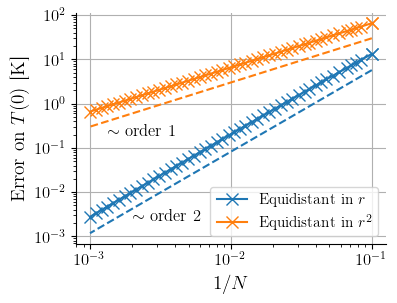

In [8]:
plt.loglog(1/N, error_final_temp_unif, 'x-', label='Equidistant in $r$')
plt.loglog(1/N, error_final_temp_nonunif, 'x-', label='Equidistant in $r^2$')

coefs = np.polyfit(np.log10(1/N), np.log10(error_final_temp_unif), 1)
print(coefs)
plt.plot(1/N, 400/N**coefs[0], '--', color='tab:blue')
plt.annotate(r'$\sim$ order 2', (0.18, 0.1), xycoords='axes fraction')
coefs = np.polyfit(np.log10(1/N), np.log10(error_final_temp_nonunif), 1)
print(coefs)
plt.plot(1/N, 300/N**coefs[0], '--', color='tab:orange')
plt.annotate(r'$\sim$ order 1', (0.1, 0.47), xycoords='axes fraction')

plt.xlabel(r'$1/N$')
plt.ylabel(r'Error on $T(0)$ [K]')
plt.legend()
plt.grid()
plt.savefig(export_path + 'convergence_temp_N_constant.pdf')

[1.84315778 5.38683467]
[1.99797549 5.41816855]


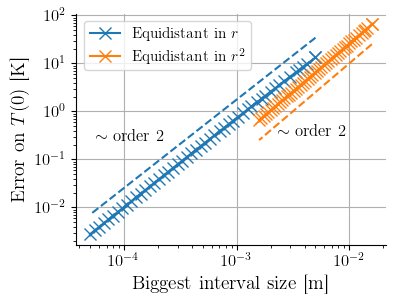

In [9]:
plt.loglog(unif_max_interval, error_final_temp_unif, 'x-', label='Equidistant in $r$')
plt.loglog(nonunif_max_interval, error_final_temp_nonunif, 'x-', label='Equidistant in $r^2$')

coefs = np.polyfit(np.log10(unif_max_interval), np.log10(error_final_temp_unif), 1)
print(coefs)
plt.plot(unif_max_interval, 6e5*unif_max_interval**coefs[0], '--', color='tab:blue')
plt.annotate(r'$\sim$ order 2', (0.06, 0.45), xycoords='axes fraction')
coefs = np.polyfit(np.log10(nonunif_max_interval), np.log10(error_final_temp_nonunif), 1)
print(coefs)
plt.plot(nonunif_max_interval, 1e5*nonunif_max_interval**coefs[0], '--', color='tab:orange')
plt.annotate(r'$\sim$ order 2', (0.65, 0.47), xycoords='axes fraction')

plt.xlabel(r'Biggest interval size [m]')
plt.ylabel(r'Error on $T(0)$ [K]')
plt.legend()
plt.grid()
plt.savefig(export_path + 'convergence_temp_interval_constant.pdf')

## Turn up the heat

In [10]:
error_final_heat_unif = np.zeros(len(N))
error_balance_unif = np.zeros(len(N))
error_final_heat_nonunif = np.zeros(len(N))
error_balance_nonunif = np.zeros(len(N))
for i, (params, temp, heat) in enumerate(data_unif):
    error_final_heat_unif[i] = abs(heat[-1,1] - final_heat_th)
    gamma_Q = 2 * np.pi * heat[-1,0] * heat[-1,1]
    error_balance_unif[i] = abs(gamma_Q - Ptot)

for i, (params, temp, heat) in enumerate(data_nonunif):
    error_final_heat_nonunif[i] = abs(heat[-1,1] - final_heat_th)
    gamma_Q = 2 * np.pi * heat[-1,0] * heat[-1,1]
    error_balance_nonunif[i] = abs(gamma_Q - Ptot)

[0.99093189 1.07368778]
[0.99991557 0.79567527]


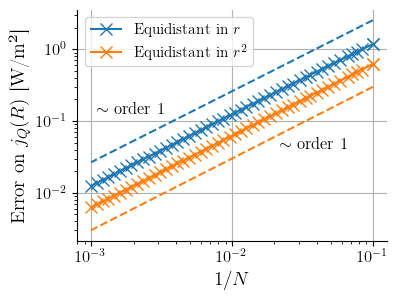

In [11]:
plt.loglog(1/N, error_final_heat_unif, 'x-', label='Equidistant in $r$')
plt.loglog(1/N, error_final_heat_nonunif, 'x-', label='Equidistant in $r^2$')

coefs = np.polyfit(np.log10(1/N), np.log10(error_final_heat_unif), 1)
print(coefs)
plt.plot(1/N, 2.5e1/N**coefs[0], '--', color='tab:blue')
plt.annotate(r'$\sim$ order {:.0f}'.format(round(coefs[0])), (0.06, 0.55), xycoords='axes fraction')
coefs = np.polyfit(np.log10(1/N), np.log10(error_final_heat_nonunif), 1)
print(coefs)
plt.plot(1/N, 3e0/N**coefs[0], '--', color='tab:orange')
plt.annotate(r'$\sim$ order {:.0f}'.format(round(coefs[0])), (0.65, 0.40), xycoords='axes fraction')

plt.xlabel(r'$1/N$')
plt.ylabel(r'Error on $j_Q(R)$ [W/m²]')
plt.legend()
plt.grid()
plt.savefig(export_path + 'convergence_heat_N_constant.pdf')

[0.99126953 0.87268645]
[1.         0.59405989]


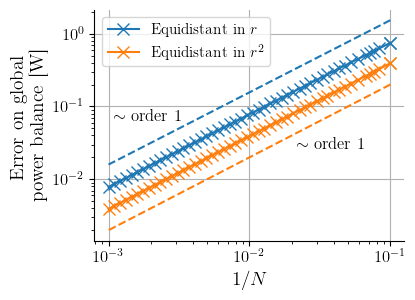

In [12]:
plt.loglog(1/N, error_balance_unif, 'x-', label='Equidistant in $r$')
plt.loglog(1/N, error_balance_nonunif, 'x-', label='Equidistant in $r^2$')

coefs = np.polyfit(np.log10(1/N), np.log10(error_balance_unif), 1)
print(coefs)
plt.plot(1/N, 1.5e1/N**coefs[0], '--', color='tab:blue')
plt.annotate(r'$\sim$ order {:.0f}'.format(round(coefs[0])), (0.06, 0.52), xycoords='axes fraction')
coefs = np.polyfit(np.log10(1/N), np.log10(error_balance_nonunif), 1)
print(coefs)
plt.plot(1/N, 2e0/N**coefs[0], '--', color='tab:orange')
plt.annotate(r'$\sim$ order {:.0f}'.format(round(coefs[0])), (0.65, 0.40), xycoords='axes fraction')

plt.xlabel(r'$1/N$')
plt.ylabel(r'Error on global\\power balance [W]')
plt.legend()
plt.grid()
plt.savefig(export_path + 'convergence_power_balance_N_constant.pdf')